# Planetary Ephemerides & Coordinates

* The trajectory followed by an astronomical object is also called ephemeris. In former times, astronomers observed planetary positions on a daily basis and noted the positions in tables.
* Planetary ephemerides (singular: ephemeris) are tables or datasets that provide the positions of astronomical objects in the sky at given times. These objects typically include planets, moons, asteroids, comets, and spacecraft. The term "ephemeris" comes from Latin and originally from the Greek word "ephémeros," meaning "diary" or "calendar."
* Planetary ephemerides are specific to the positions of planets. They give detailed information about the location of planets in the sky at various times. This can include their coordinates in various celestial coordinate systems, such as right ascension and declination, or their distance from the Earth or the Sun.
* While planetary ephemerides refer specifically to planets, the term "ephemeris" can be used more broadly for any celestial body. An ephemeris can provide data on stars, galaxies, artificial satellites, and other astronomical objects.
*  Ephemerides are calculated using mathematical models of celestial mechanics, incorporating the laws of gravity and motion. These calculations take into account various factors such as gravitational interactions between bodies, perturbations, and relativistic effects.
* Various institutions, like NASA's Jet Propulsion Laboratory (JPL) and the International Astronomical Union (IAU), publish ephemerides.
* To compute such secular variations over many orbital periods with high accuracy, analytical and numerical calculations using perturbation techniques are applied. An example is the VSOP (**Variations Séculaires des Orbites Planétaires**). The solution known as VSOP87 represents the time-dependent heliocentric coordinates X,Y,Z of the planets in the solar system (including Pluto) by series expansions, which are available as source code in several programming languages.
*VSOP87 Model:
> $P = \sum A \cdot \cos(B + C \cdot t)$

where:

$P$: the planetary position in one of the heliocentric coordinates

$A$, $B$, $C$: coefficients specific to each planet and coordinate

$t$: time in Julian centuries from the J2000.0 epoch

In [1]:
%%capture
!pip install skyfield

In [57]:
from skyfield.api import load,Topos,Star
from skyfield.data import hipparcos
from skyfield.positionlib import ITRF_to_GCRS

In [53]:
import math,astropy
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
plt.style.use("dark_background")
%matplotlib inline

In [4]:
def ConvertJulianDate(day:int,month:int,year:int,universelTime:int or float)->int or float:
  if (month <= 2):
    yearBase = year-1
    monthBase = month+12
  else:
    yearBase = year
    monthBase = month
  if (year < 1582):
    base = -2
  elif (year == 1582):
    if (month < 10):
      base = -2
    elif (month == 10):
      if (day <= 4):
        base = -2
      else:
        base = math.floor(year/400)-math.floor(year/100)
    else:
      base = math.floor(year/400)-math.floor(year/100)
  else:
    base = math.floor(year/400)-math.floor(year/100)
  return math.floor(365.25*year)+math.floor(30.6001*(month+1))+base+1720996.5+day+universelTime/24


In [5]:
now = datetime.utcnow()
print(f"UTC - Now: {now}")

UTC - Now: 2023-12-17 18:55:24.825877


In [6]:
julianDate = ConvertJulianDate(now.day,now.month,now.year,now.hour+now.minute/60+now.second/3600)
print(f"Julian Date: {julianDate}")

Julian Date: 2460296.288472222


In [7]:
# Load ephemeris data (DE421 includes VSOP87 model data)
planets = load("de421.bsp")

[#################################] 100% de421.bsp


In [8]:
planets.__dict__

{'path': 'de421.bsp',
 'filename': 'de421.bsp',
 'spk': <jplephem.spk.SPK at 0x7a708af6b6d0>,
 'segments': [<ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 1 MERCURY BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 2 VENUS BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 4 MARS BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 5 JUPITER BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 6 SATURN BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 7 URANUS BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 8 NEPTUNE BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 9 PLUTO BARYCENTER>,
  <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -

In [9]:
earthData = planets["earth"]
print(f"Earth Data:\n{earthData}")

Earth Data:
Sum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER
 'de421.bsp' segment 3 EARTH BARYCENTER -> 399 EARTH


In [10]:
timeScale = load.timescale()
print(f"Time Scale - J2000:\n{timeScale.J2000}")

Time Scale - J2000:
<Time tt=2451545.0>


In [11]:
UTCNow = timeScale.utc(now.year,now.month,now.day)
print(f"Now - UTC - Additional Method: {UTCNow}")

Now - UTC - Additional Method: <Time tt=2460295.500800741>


In [12]:
observedPlanet = planets["mars"]

In [13]:
earthAstrometric = earthData.at(UTCNow)
print(f"Astrometric Values for Earth:\n{earthAstrometric}")

Astrometric Values for Earth:
<Barycentric BCRS position and velocity at date t center=0 target=399>


In [14]:
positionObservedPlanet = earthData.at(UTCNow).observe(observedPlanet)
print(f"Right Ascension-Mars: {positionObservedPlanet.radec()[0]}")
print(f"Declination-Mars: {positionObservedPlanet.radec()[1]}")
print(f"Distance-Mars: {positionObservedPlanet.radec()[2]}")

Right Ascension-Mars: 16h 58m 46.17s
Declination-Mars: -23deg 05' 42.9"
Distance-Mars: 2.46633 au


In [15]:
def GetPlanetPosition(planetName:str,date:int or float)->tuple:
  planet = planets[planetName]
  timeUTC = timeScale.utc(date.year,date.month,date.day)
  astrometric = earthData.at(timeUTC).observe(planet)
  ra,dec,distance = astrometric.radec()
  return ra,dec,distance

In [16]:
raVENUS,decVENUS,distanceVENUS = GetPlanetPosition("VENUS",datetime(2023,12,15))
print(f"Right Ascension-VENUS: {raVENUS}")
print(f"Declination-VENUS: {decVENUS}")
print(f"Distance-VENUS: {distanceVENUS}")

Right Ascension-VENUS: 14h 40m 13.86s
Declination-VENUS: -13deg 13' 10.4"
Distance-VENUS: 1.07117 au


* If ($x_1$, $y_1$, $z_1$) and ($x_2$, $y_2$, $z_2$) are the coordinates of two points in 3D space, the distance:
> $d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}$

In [17]:
sunData = planets["sun"]
timeNow = UTCNow = timeScale.now()
print(f"Current Time:\n{timeNow}")
astrometricEarth = sunData.at(timeNow).observe(earthData)
positionEarth = astrometricEarth.position
print(f"Position-Earth:\n{positionEarth}")
print(f"Position-Distance-Earth:\n{positionEarth.au}")

Current Time:
<Time tt=2460296.2893171157>
Position-Earth:
[0.08178029 0.89978588 0.39004728] au
Position-Distance-Earth:
[0.08178029 0.89978588 0.39004728]


In [18]:
def DistanceCalculation(coordsOne:tuple or list,coordsTwo:tuple or list)->int or float:
  x1,y1,z1 = coordsOne
  x2,y2,z2 = coordsTwo
  distance = math.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
  return distance

In [19]:
def GetPlanetCoordinates(planetName:str,time:int or float)->tuple or list:
  planet = planets[planetName]
  astrometric = sunData.at(time).observe(planet)
  return astrometric.position.au

In [20]:
nowTimeBase = timeScale.now()
print(f"Time-Current:\n{nowTimeBase}")
earthCoord = GetPlanetCoordinates("earth",nowTimeBase)
venusCoord = GetPlanetCoordinates("venus",nowTimeBase)

Time-Current:
<Time tt=2460296.289317708>


In [21]:
print(f"Earth Coordinate: {earthCoord}")
print(f"Venus Coordinate: {venusCoord}")

Earth Coordinate: [0.08178028 0.89978588 0.39004728]
Venus Coordinate: [-0.6867875   0.17486632  0.12213489]


In [22]:
distanceBetweenVenusEarth = DistanceCalculation(earthCoord,venusCoord)
print(f"Distance From Earth to Venus: {distanceBetweenVenusEarth} AU")

Distance From Earth to Venus: 1.089945804986788 AU


In [23]:
def EarthVenusDistanceReturn(timeRange:list)->list:
  distances = []
  for date in timeRange:
    earthPos = GetPlanetCoordinates("earth",date)
    venusPos = GetPlanetCoordinates("venus",date)
    distance = DistanceCalculation(earthPos,venusPos)
    distances.append(distance)
  return distances

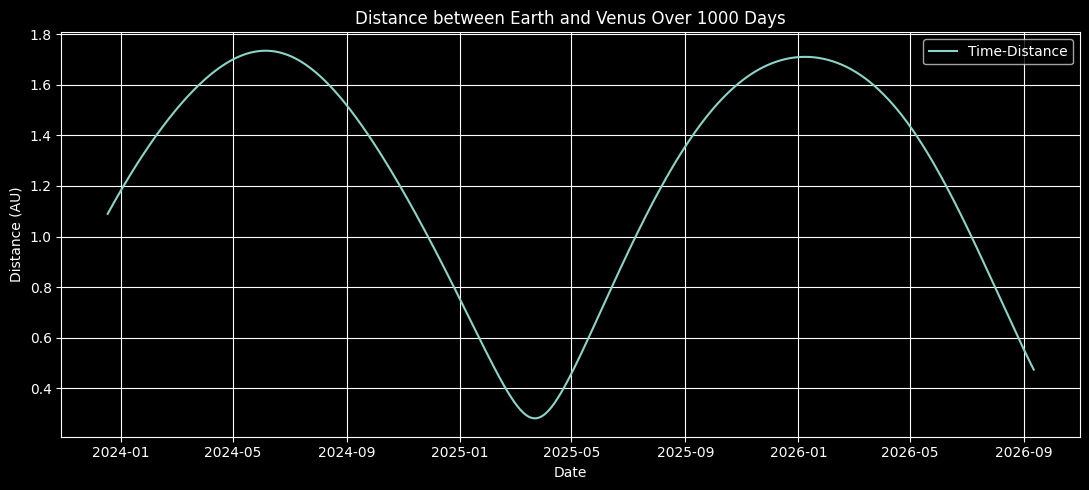

In [24]:
currentJulian = timeScale.now().tt
timeRange = [timeScale.tt_jd(currentJulian+index) for index in range(1000)] # Over 1000 Days
distances = EarthVenusDistanceReturn(timeRange)
plt.figure(figsize=(11,5))
plt.title("Distance between Earth and Venus Over 1000 Days")
plt.plot([date.utc_datetime() for date in timeRange],distances,label="Time-Distance")
plt.xlabel("Date")
plt.ylabel("Distance (AU)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Example

**To observe and visualize the apparent retrograde motion of Mars from Earth's perspective**

In [25]:
def GetMarsPosition(startDate:int or float,endDate:int or float,observerLocation:tuple)->list:
  ts = load.timescale()
  planetsData = load("de421.bsp")
  mars = planetsData["mars"]
  earth = planetsData["earth"] + observerLocation
  currentDate = startDate
  positions = []
  while currentDate <= endDate:
    time = ts.utc(currentDate.year,currentDate.month,currentDate.day)
    astrometricValues = earth.at(time).observe(mars)
    ra,dec,dist = astrometricValues.radec()
    positions.append((ra.hours,dec.degrees))
    currentDate += timedelta(days=1)
  return positions

In [26]:
def PlotMarsMotion(positions:list)->None:
  raValues,decValues = zip(*positions)
  plt.figure(figsize=(11,5))
  plt.plot(raValues,decValues,"o-")
  plt.xlabel("Right Ascension (hours)")
  plt.ylabel("Declination (degrees)")
  plt.title("Apparent Motion of Mars Over Several Months")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [27]:
observerLocation = Topos("40.7128 N","74.0060 W") # Example: New York City

In [28]:
print(f"Observer:\n{observerLocation}")

Observer:
IERS2010 latitude +40.7128 N longitude -74.0060 E elevation 0.0 m


In [29]:
startDate = datetime(2023,1,1)
endDate = datetime(2023,6,30)

In [30]:
print(f"Start from: {startDate}")
print(f"End to: {endDate}")

Start from: 2023-01-01 00:00:00
End to: 2023-06-30 00:00:00


In [31]:
marsPosition = GetMarsPosition(startDate,endDate,observerLocation)

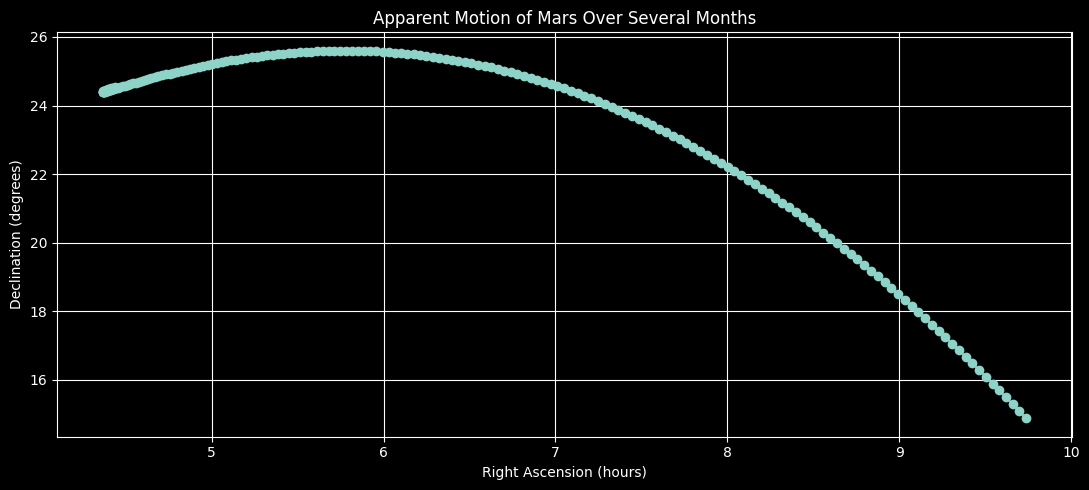

In [32]:
PlotMarsMotion(marsPosition)

## Example

**The Two-Line Element set (TLE) is a data format encoding a list of orbital elements of an Earth-orbiting object for a given point in time.**

**We can use it for tracking the International Space Station (ISS)**

In [33]:
def FetchTLEData()->dict:
  tleURL = "http://celestrak.com/NORAD/elements/stations.txt"
  satellites = load.tle_file(tleURL)
  iss = {sat.name: sat for sat in satellites}["ISS (ZARYA)"]
  return iss

In [34]:
issDATA = FetchTLEData()
print(f"ISS:\n{issDATA}")

[#################################] 100% stations.txt


ISS:
ISS (ZARYA) catalog #25544 epoch 2023-12-17 13:50:26 UTC


In [35]:
def CalculateISSPosition(issData:dict,time:int or float)->str or tuple:
  return issData.at(time)

In [36]:
def PredictOverflights(issData:dict,observerLocation:tuple,startTime:int or float,endTime:int or float)->tuple:
  timeScale = load.timescale()
  time,events = issData.find_events(observerLocation,startTime,endTime,altitude_degrees=30)
  return time,events

In [51]:
def CalculateDistanceISS(issData:dict,observerLocation:tuple,timeBase:int or float)->int or float:
  time = timeBase.now()
  issPosition = issData.at(time).position.km
  # Convert observer location to GCRS
  observerPosition = observerLocation.at(time).position.km
  distance = np.linalg.norm(issPosition-observerPosition)
  return distance

In [37]:
timeScaleBase = load.timescale()
observerLocation = Topos("40.7128 N","74.0060 W") # Example: New York City
startTime = timeScaleBase.now()
endTime = timeScaleBase.utc(startTime.utc_datetime()+timedelta(days=1))

In [38]:
issData = FetchTLEData()
issPosition = CalculateISSPosition(issData,startTime)

In [40]:
print(f"ISS position at {startTime.utc_datetime()}: {issPosition.position.km} [KM BASE]")

ISS position at 2023-12-17 19:05:51.547633+00:00: [ 5243.69534976   -60.43093489 -4327.48630063] [KM BASE]


In [43]:
times,events = PredictOverflights(issData,observerLocation,startTime,endTime)
for time,event in zip(times,events):
  print(event)
  name = ("rise","culminate","set")[event]
  print(f"{time.utc_datetime()} {name}\n")

0
2023-12-18 11:20:17.074456+00:00 rise

1
2023-12-18 11:21:41.428897+00:00 culminate

2
2023-12-18 11:23:06.309949+00:00 set

0
2023-12-18 17:50:01.634722+00:00 rise

1
2023-12-18 17:51:00.902677+00:00 culminate

2
2023-12-18 17:52:00.027683+00:00 set



In [52]:
distanceISS = CalculateDistanceISS(issData,observerLocation,timeScaleBase)
print(f"Distance from ISS to New York City: {distanceISS:.2f} km")

Distance from ISS to New York City: 12562.82 km


## Example

**Create a sky chart showing the positions of stars, planets, and major constellations from a given location and time.**

In [176]:
planets = load("de421.bsp") # ephemeris DE421

In [177]:
planets.segments

[<ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 1 MERCURY BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 2 VENUS BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 4 MARS BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 5 JUPITER BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 6 SATURN BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 7 URANUS BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 8 NEPTUNE BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 9 PLUTO BARYCENTER>,
 <ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN>,
 <ChebyshevPosition 'de421.bsp' segment 3 EARTH BARYCENTER -> 301 MOON>,
 <ChebyshevPosition 'de421.bsp' 

In [168]:
planets["MOON"]

<VectorSum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER
 'de421.bsp' segment 3 EARTH BARYCENTER -> 301 MOON>

In [172]:
planets["JUPITER BARYCENTER"]

<ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 5 JUPITER BARYCENTER>

In [119]:
earthData = planets["earth"]

In [122]:
observerLocation = Topos("40.7128 N","74.0060 W") # NW
timeBase = load.timescale()
observingTime = timeBase.utc(2018,9, 3)

In [147]:
with load.open(hipparcos.URL) as hFile:
    stars = hipparcos.load_dataframe(hFile)

In [148]:
stars = stars[stars["magnitude"] <= 2.5]
print(f"Found {len(stars)} - Depends on Magnitude <= 2.5")

Found 93 - Depends on Magnitude <= 2.5


In [149]:
stars

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year
hip,,,,,,,,
677,2.07,2.096533,29.090828,33.60,135.68,-162.95,0.139769,1991.25
746,2.28,2.292040,59.150218,59.89,523.39,-180.42,0.152803,1991.25
2081,2.40,6.570281,-42.305122,42.14,232.76,-353.64,0.438019,1991.25
3179,2.24,10.126613,56.537409,14.27,50.36,-32.17,0.675108,1991.25
3419,2.04,10.896785,-17.986684,34.04,232.79,32.71,0.726452,1991.25
...,...,...,...,...,...,...,...,...
109268,1.73,332.057818,-46.960616,32.16,127.60,-147.91,22.137188,1991.25
112122,2.07,340.666395,-46.884566,19.17,135.68,-4.51,22.711093,1991.25
113368,1.17,344.411773,-29.621837,130.08,329.22,-164.22,22.960785,1991.25


In [150]:
starFrame = Star.from_dataframe(stars)
observer = earthData + observerLocation
astrometric = observer.at(observingTime).observe(starFrame)

In [155]:
starFrame

Star(ra shape=93, dec shape=93, ra_mas_per_year shape=93, dec_mas_per_year shape=93, parallax_mas shape=93, epoch shape=93)

In [151]:
alt,az,d = astrometric.apparent().altaz()

In [152]:
alt

<Angle 93 values from 15deg 35' 54.3" to 18deg 39' 03.0">

In [153]:
az

<Angle 93 values from 64deg 40' 08.8" to 85deg 34' 35.8">

In [154]:
d

<Distance [6.13883277e+06 3.44406053e+06 4.89475023e+06 1.44544359e+07
 6.05948228e+06 3.87715798e+07 1.26078727e+07 9.09456767e+06
 2.24444834e+07 4.16864955e+06 2.72837047e+07 5.86980074e+06
 3.74346290e+07 4.11788392e+06 4.88779163e+07 2.66871291e+06
 1.53699559e+07 8.28705550e+06 5.79395525e+07 8.48826365e+07
 5.16954404e+07 4.56338069e+07 2.70333956e+07 5.19297126e+06
 3.15872601e+07 1.97761081e+07 6.62804695e+06 5.43933366e+05
 2.72476631e+07 1.13332312e+08 2.02220399e+08 3.26007344e+06
 7.21382875e+05 2.13215704e+06 8.85256684e+07 5.31610330e+07
 3.99738000e+07 5.04314968e+06 3.62504059e+07 7.03015719e+06
 4.37929528e+07 3.40933568e+07 1.12100447e+07 4.90056659e+06
 7.94548659e+06 5.02227498e+06 7.81898491e+06 2.28776502e+06
 5.29019832e+06 2.02816922e+07 5.56119764e+06 8.24729381e+06
 2.22988983e+07 5.11823399e+06 4.94284279e+06 1.65807729e+07
 2.37632269e+07 6.36816377e+06 3.32149449e+07 3.85397666e+06
 2.32149546e+06 1.95141731e+07 2.77940141e+05 2.77940141e+05
 3.46663542e+0

In [180]:
def PlotNightSky(observerLocation:tuple,observingTime:int or float or tuple,titleCoord:str)->None:
  timeBase = load.timescale()
  timeUTC = timeBase.utc(
      observingTime.year,
      observingTime.month,
      observingTime.day,
      observingTime.hour,
      observingTime.minute
  )
  planets = load("de421.bsp")
  earthData = planets["earth"]
  with load.open(hipparcos.URL) as hFile:
    stars = hipparcos.load_dataframe(hFile)
  stars = stars[stars["magnitude"] <= 2.5]
  print(f"Found {len(stars)} - Depends on Magnitude <= 2.5")
  figure = plt.figure(figsize=(11,11))
  ax = plt.subplot(111,polar=True)
  for planetName in ['mercury','venus','mars','moon','JUPITER BARYCENTER','SATURN BARYCENTER','URANUS BARYCENTER','NEPTUNE BARYCENTER']:
    planetData = planets[planetName]
    observer = earthData + observerLocation
    astrometricPlanet = observer.at(timeUTC).observe(planetData)
    alt,az,d = astrometricPlanet.apparent().altaz()
    if alt.degrees > 0: # Only plot if above the horizon
      ax.annotate(
          planetName.upper(),
          xy=(np.radians(az.degrees),90-alt.degrees),
          xytext=(5,5),
          textcoords="offset points"
      )
      ax.scatter(
          np.radians(az.degrees),
          90-alt.degrees,
          color="white",
          label=planetName.capitalize())
  observer = earthData + observerLocation
  for starID in stars.index[:200]:
    star = Star.from_dataframe(stars.loc[starID])
    astrometricStar = observer.at(timeUTC).observe(star)
    alt,az,d = astrometricStar.apparent().altaz()
    if alt.degrees > 0: # Only plot if above the horizon
      ax.scatter(
          np.radians(az.degrees),
          90-alt.degrees,
          color="yellow",
          s=0.7
          )
  ax.set_title(f"From: {observerLocation} / {titleCoord}")
  ax.set_theta_zero_location("N")
  ax.set_theta_direction(-1)
  ax.set_ylim(0,90)
  ax.set_yticks(range(0,91,30))
  ax.set_yticklabels(['90°','60°','30°','Horizon'])
  ax.legend()
  plt.tight_layout()
  plt.show()


Found 93 - Depends on Magnitude <= 2.5


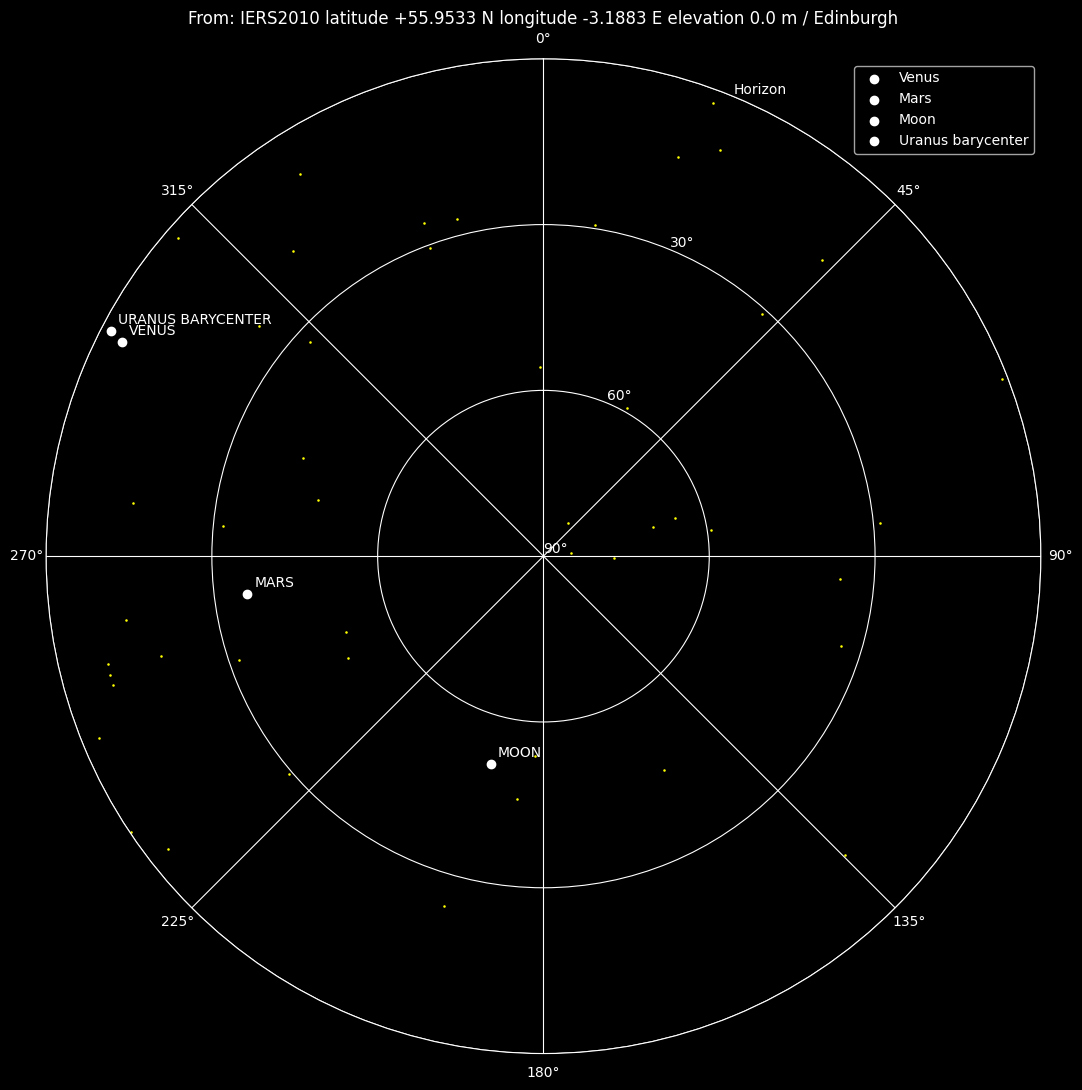

In [181]:
observerLocation = Topos("55.9533 N","3.1883 W") # Edinburgh / Coordinates
observingLocal = datetime(2023,4,1,22,0)  # 10:00 PM local time
PlotNightSky(observerLocation,observingLocal,titleCoord="Edinburgh")